<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# Parallelize code with `dask.delayed`

In this section we parallelize simple for-loop style code with Dask and `dask.delayed`. Often, this is the only function that you will need to convert functions for use with Dask.

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask).  This will also help us to develop an understanding for later sections.

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As well see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## 基本

首先让我们制作一些玩具功能，例如inc和add，它们会休眠一段时间以模拟工作。 然后，我们将正常运行这些功能。

在下一节中，我们将并行化此代码。


In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 220 ms, sys: 36.1 ms, total: 256 ms
Wall time: 3 s


### 使用`dask.delayed`装饰器并行

可以并行调用这两个增量调用，因为它们完全彼此独立。

我们将使用`dask.delayed`函数来转换`inc`和`add`函数。 当我们通过传递参数来调用延迟版本时，与以前完全一样，但是实际上尚未调用原始函数-这就是为什么单元执行非常快地完成的原因。
而是创建了一个“延迟对象”，该对象跟踪要调用的函数以及要传递给该函数的参数。

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 5.63 ms, sys: 0 ns, total: 5.63 ms
Wall time: 4.29 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 159 ms, sys: 46.2 ms, total: 205 ms
Wall time: 2.05 s


5

## 刚才发生了什么？

`z`对象是一个懒惰(`lazy`)的`Delayed`对象。 该对象包含我们计算最终结果所需的一切，包括对所有必需功能的引用以及它们的输入以及与另一个函数的关系。 我们可以如上所述使用`.compute()`评估结果，也可以使用`.visualize()`可视化该值的任务图。

In [7]:
z

Delayed('add-5a27fda5-4884-4ebe-95b8-8c5a9bb3346e')

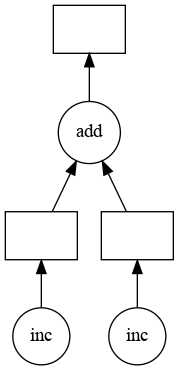

In [9]:
# Look at the task graph for `z`
z.visualize()

注意，这包括之前的函数名称，以及`inc`函数的输出到`add`的输入的逻辑流程。

### 需要考虑的一些问题：

-为什么我们从3秒变成2秒？ 为什么我们不能并行化到1s？  
-如果inc和add函数不包含`sleep(1)`会发生什么？ Dask仍然可以加快此代码的速度吗？  
-如果我们有多个输出或者还想访问`x`或`y`，该怎么办？  

## 练习：并行处理for循环

`for`循环是我们要并行化的最常见的事物之一。 在`inc`和`sum`上使用`dask.delayed`来并行化以下计算：

In [10]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 599 ms, sys: 95 ms, total: 694 ms
Wall time: 8.01 s


In [12]:
total

44

In [ ]:
%%time
# Your parallel code here...

In [ ]:
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
delayed(inc)(1) + delayed(inc)(2)
```

## Exercise: Parallelizing a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [ ]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

In [ ]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

In [ ]:
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

In [ ]:
%time total.compute()

In [ ]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

## Create data

Run this code to prep some data.

This downloads and extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is originally from [here](http://stat-computing.org/dataexpo/2009/the-data.html).

In [ ]:
%run prep.py -d flights

### Inspect data

In [ ]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

In [ ]:
# What is the schema?
df.dtypes

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

### Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
from dask import compute

In [ ]:
%%time

# copied sequential code

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
mean

In [ ]:
%%time
# your code here

If you load the solution, add `%%time` to the top of the cell to measure the running time.

In [ ]:
%%time

# This is just one possible solution, there are
# several ways to do this using `delayed`

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

In [ ]:
# ensure the results still match
mean

### Some questions to consider:

- How much speedup did you get? Is this how much speedup you'd expect?
- Experiment with where to call `compute`. What happens when you call it on `sums` and `counts`? What happens if you wait and call it on `mean`?
- Experiment with delaying the call to `sum`. What does the graph look like if `sum` is delayed? What does the graph look like if it isn't?
- Can you think of any reason why you'd want to do the reduction one way over the other?

### Learn More

Visit the [Delayed documentation](https://docs.dask.org/en/latest/delayed.html). In particular, this [delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU) will reinforce the concepts you learned here and the [delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html) document collects advice on using `dask.delayed` well.

## Close the Client

Before moving on to the next exercise, make sure to close your client or stop this kernel.

In [ ]:
client.close()